In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import numpy as np
import math
import time
import os

In [22]:
ORIGIN_DATA_SIZE = 12500
TARGET_DATA_SIZE = 12500
RATIO = 0.99
EPOCH = 4
BATCH_SIZE = 7
LOSS_FUNC = nn.BCELoss()
LR = 0.0001
UPDATE = 5

In [15]:
torch.cuda.empty_cache()
INPUT_PATH = os.getcwd()+'\\kaggle'
OUTPUT_PATH = os.getcwd()+'\\kaggle'

In [16]:
TRANSFORM = transforms.Compose([transforms.Resize((256,256)),
                                transforms.RandomCrop((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
                               ])

In [5]:
class VGG(nn.Module):#16
    def __init__(self):
        super(VGG, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        self.fc = nn.Sequential(
            nn.Linear(512*7*7,4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096,4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096,1000),
            nn.ReLU(),
            nn.Linear(1000,1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [56]:
class VGG(nn.Module):#11
    def __init__(self):
        super(VGG, self).__init__()
        self.conv = nn.Sequential()
        i = 1; p = 1
        self.conv.add_module('conv-{0}'.format(i),nn.Conv2d(in_channels=  3, out_channels= 64, kernel_size=3, stride=1, padding=1))
        self.conv.add_module('ReLU-{0}'.format(i),nn.ReLU());i+=1
        self.conv.add_module('LRN',nn.LocalResponseNorm(size=2))
        self.conv.add_module('MaxPooling-{0}'.format(p),nn.MaxPool2d(kernel_size=2, stride=2));p+=1   # 224 -> 112
        self.conv.add_module('conv-{0}'.format(i),nn.Conv2d(in_channels= 64, out_channels=128, kernel_size=3, stride=1, padding=1))
        self.conv.add_module('ReLU-{0}'.format(i),nn.ReLU());i+=1
        self.conv.add_module('MaxPooling-{0}'.format(p),nn.MaxPool2d(kernel_size=2, stride=2));p+=1   # 112 -> 56
        self.conv.add_module('conv-{0}'.format(i),nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1))
        self.conv.add_module('ReLU-{0}'.format(i),nn.ReLU());i+=1
        self.conv.add_module('conv-{0}'.format(i),nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1))
        self.conv.add_module('ReLU-{0}'.format(i),nn.ReLU());i+=1
        self.conv.add_module('MaxPooling-{0}'.format(p),nn.MaxPool2d(kernel_size=2, stride=2));p+=1   # 56 -> 28
        self.conv.add_module('conv-{0}'.format(i),nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1))
        self.conv.add_module('ReLU-{0}'.format(i),nn.ReLU());i+=1
        self.conv.add_module('conv-{0}'.format(i),nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1))
        self.conv.add_module('ReLU-{0}'.format(i),nn.ReLU());i+=1
        self.conv.add_module('MaxPooling-{0}'.format(p),nn.MaxPool2d(kernel_size=2, stride=2));p+=1   # 28 -> 14
        self.conv.add_module('conv-{0}'.format(i),nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1))
        self.conv.add_module('ReLU-{0}'.format(i),nn.ReLU());i+=1
        self.conv.add_module('conv-{0}'.format(i),nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1))
        self.conv.add_module('ReLU-{0}'.format(i),nn.ReLU());i+=1
        self.conv.add_module('MaxPooling-{0}'.format(p),nn.MaxPool2d(kernel_size=2, stride=2));p+=1   # 14 -> 7
        self.fc = nn.Sequential(
            nn.Linear(512*7*7,4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096,4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096,1000),
            nn.ReLU(),
            nn.Linear(1000,1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [6]:
class ImageDataset(data.Dataset):
    def __init__(self, image_list, label_list):
        self.data = image_list
        self.label = label_list
 
    def __getitem__(self, index):
        global TRANSFORM
        img = Image.open(self.data[index])
        data = TRANSFORM(img)
        img.close()
        return data.cuda(),torch.cuda.FloatTensor([self.label[index]])
 
    def __len__(self):
        return len(self.data)

In [7]:
def load():
    np.random.seed(998244353)
    torch.manual_seed(998244353)
    image_list = []
    label_list = []
    for i in range(ORIGIN_DATA_SIZE):
        image_list.append(INPUT_PATH+"\\train\\cat.{0}.jpg".format(i))
        label_list.append(0)
        image_list.append(INPUT_PATH+"\\train\\dog.{0}.jpg".format(i))
        label_list.append(1)
    n = int(ORIGIN_DATA_SIZE*2*RATIO)
    train_data = ImageDataset(image_list[:n],label_list[:n])
    validate_data = ImageDataset(image_list[n:],label_list[n:])
    image_list = []
    for i in range(TARGET_DATA_SIZE):
        image_list.append(INPUT_PATH+"\\test1\\{0}.jpg".format(i+1))
    test_data = ImageDataset(image_list,[0]*TARGET_DATA_SIZE)
    # np.random.seed()
    # torch.seed()
    return train_data,validate_data,test_data

In [23]:
time_start=time.time()
PROGRAM_START = time.time()
train_data,validate_data,test_data = load()
print("读取数据集完成时间 %.4f s."%(time.time()-PROGRAM_START))

读取数据集完成时间 0.0190 s.


In [24]:
torch.cuda.is_available()

True

In [25]:
torch.cuda.device_count()

1

In [26]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 2060'

In [27]:
net=VGG().cuda()
optimizer = optim.RMSprop(net.parameters(), lr=LR, alpha=0.9)
LOSS_FUNC.cuda()
#加载数据
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
validate_loader = data.DataLoader(validate_data, batch_size=1, shuffle=False, num_workers=0)

BATCH = len(train_loader)
m = len(validate_loader)

loss_list=list()
for epoch in range(EPOCH):
    EPOCH_START = time.time()
    print("轮次 #{0}\\{1}:".format(epoch+1,EPOCH))
    
    for batch,(x,y) in enumerate(train_loader):
        optimizer.zero_grad()
        t = net(x)
        loss = LOSS_FUNC(t,y)
        loss_list.append(loss)
        if batch%100==0:
            print("batch {0}\\{1}: ".format(batch+1,BATCH) + "Loss = %.6f"%float(loss))
        loss.backward()
        optimizer.step()
    #保存每一epoch的模型
    with torch.no_grad():
        L = 0.
        E = 0.
        for batch,(x,y) in enumerate(validate_loader):
            t = net(x)
            L += float(LOSS_FUNC(t,y))
            E += float((float(t[0][0])>0.5)!=y)
        print("\t  Validation Loss = %.6f. Error Rate = %.3f%%"%(L/m,E*100/m))
        if((epoch+1)%UPDATE==0):
            torch.save(net.state_dict(),OUTPUT_PATH+"\\{0}[{1}]".format(net.name,epoch+1)+"-L(%.6f)E(%.3f).pt"%(L/m,E*100/m))
            torch.save(optimizer.state_dict(),OUTPUT_PATH+"\\{0}[{1}]".format(net.name,epoch+1)+"-L(%.6f)E(%.3f)-optimizer.pt"%(L/m,E*100/m))
    print("\t 完成第{0}轮".format(epoch+1)+" 耗时 %.4f s."%(time.time()-EPOCH_START)+
          " 总耗时 = %.4f s."%(time.time()-PROGRAM_START))


轮次 #1\4:
batch 1\3536: Loss = 0.692981
batch 101\3536: Loss = 0.698816
batch 201\3536: Loss = 0.689805
batch 301\3536: Loss = 0.705055
batch 401\3536: Loss = 0.703498
batch 501\3536: Loss = 0.688590
batch 601\3536: Loss = 0.786001
batch 701\3536: Loss = 0.684260
batch 801\3536: Loss = 0.708548
batch 901\3536: Loss = 0.612567
batch 1001\3536: Loss = 0.713203
batch 1101\3536: Loss = 0.650091
batch 1201\3536: Loss = 0.608355
batch 1301\3536: Loss = 0.572527
batch 1401\3536: Loss = 1.070547
batch 1501\3536: Loss = 0.537307
batch 1601\3536: Loss = 0.555364
batch 1701\3536: Loss = 0.502724
batch 1801\3536: Loss = 0.580899
batch 1901\3536: Loss = 0.537893
batch 2001\3536: Loss = 0.892502
batch 2101\3536: Loss = 0.583576
batch 2201\3536: Loss = 0.715771
batch 2301\3536: Loss = 0.591309
batch 2401\3536: Loss = 0.694536
batch 2501\3536: Loss = 0.781403
batch 2601\3536: Loss = 0.333874
batch 2701\3536: Loss = 0.685296
batch 2801\3536: Loss = 0.570198
batch 2901\3536: Loss = 0.512869
batch 3001\35

In [ ]:

prediction = []
test_loader = data.DataLoader(test_data, batch_size=1, shuffle=False, num_workers=0)
with torch.no_grad():
    for i,(x,y) in enumerate(test_loader):
        t = net(x)
        prediction.append([i+1,float(t[0][0])])
submission = pd.DataFrame(prediction)
submission.columns = ['id','label']
submission.to_csv("result.csv",index=0)
submission

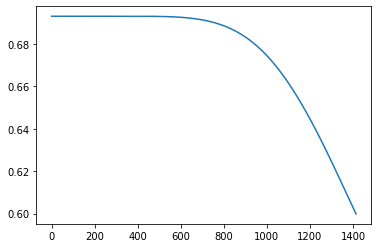

In [31]:
def smooth_(list_i):
    loss_int=list()
    loss_int.append(list_i[0])
    for i in range(1,len(list_i)):
        loss_int.append(loss_int[-1]*0.99+list_i[i]*0.01)
    return loss_int
temp=loss_list[::10]
k=smooth_(temp)
for i in range(10):
    k=smooth_(k)

plt.plot(k)

In [33]:
print(net)

VGG(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ce